In [22]:
import pandas as pd
import numpy as np

In [23]:
inf_data=pd.read_csv('../2021_ICM_Problem_D_Data/influence_data.csv',encoding='gbk')


In [34]:
artist_data=pd.read_csv('../2021_ICM_Problem_D_Data/data_by_artist.csv',encoding='utf-8')
full_music_data=pd.read_csv('../2021_ICM_Problem_D_Data/full_music_data.csv')

In [24]:
inf_data.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [25]:
node_list=inf_data['influencer_id'].unique().tolist()
for node in inf_data['follower_id']:
    if node not in node_list:
        node_list.append(node)

# 统计每个node的子节点人数

In [26]:
son_num={}#各个节点子节点数目

In [27]:
for node in node_list:
    son_num[node]=inf_data[inf_data['influencer_id']==node].shape[0]

In [28]:
inf_data[inf_data['influencer_id']==759491].loc[:,'follower_id'].values.tolist()

[74,
 55778,
 258430,
 317545,
 335747,
 371258,
 404734,
 471355,
 573241,
 662225,
 804431,
 924780]

In [37]:
inf_num_value={}#各个节点影响的人数
inf_son12_list={}#各个节点子节点孙节点的集合
#至多计算二层子节点，分别对二层子节点的数目赋权1，0.3
for node in node_list:
    lev1_list=inf_data[inf_data['influencer_id']==node].loc[:,'follower_id'].values.tolist()
    lev1_num=len(lev1_list)
    lev2_list=[]
    for node1 in lev1_list:#遍历一级子节点
        lev2_list_1=inf_data[inf_data['influencer_id']==node1].loc[:,'follower_id'].values.tolist()#该以及子节点的所有二级子节点
        for node1_1 in lev2_list_1:#将single一级子节点的二级子节点保存至该以及子节点的子节点列表中
            lev2_list.append(node1_1)
    lev2=len(lev2_list)
    count=lev1_num+0.3*lev2
    inf_num_value[node]=count
    son_list=[]
    for lev1_node in lev1_list:
        son_list.append(lev1_node)
    for lev2_node in lev2_list:
        son_list.append(lev2_node)
    inf_son12_list[node]=son_list

# 每个节点与其子节点的相似程度

In [59]:
#处理极小化指标
artist_data['liveness']=1-artist_data['liveness']
#定义纯度指标
artist_data['purity']=artist_data['liveness']+artist_data['acousticness']
#定义情感倾向指标
artist_data['emotion']=artist_data['energy']+artist_data['valence']+artist_data['mode']
#引入通过所有音乐的['danceability','tempo','loudness']三个指标进行熵权法求得的权值
w=[0.5854533265576414, 0.35210331038254183, 0.06244336305981675]
#求节奏指标
artist_data['rhythm']=w[0]*artist_data['danceability']+w[1]*artist_data['tempo']+w[2]*artist_data['loudness']
artist_feature=artist_data[['artist_id','emotion','rhythm','purity','duration_ms','popularity','instrumentalness']]

In [60]:
artist_feature.head()

,artist_id,emotion,rhythm,purity,duration_ms,popularity,instrumentalness
0,792507,1.602305,38.129297,0.967754,189179.9255,26.004383,0.020855
1,119107,1.344795,32.167501,1.173883,266541.1251,3.592378,0.879508
2,816890,2.130043,40.144125,0.927880,162279.2672,26.614130,0.022647
3,79016,1.700302,38.209818,1.126225,185131.4530,15.621005,0.013064
4,66915,2.029866,44.023121,0.871544,256713.4203,30.860806,0.034211


In [40]:
same_dict={}
for node in inf_num_value.keys():
    same_dict[node]=[]

In [42]:
# 各个指标“相似”的范围
limit={
    'emotion':0.5,
'rhythm':5,
'purity':0.25,
'duration_ms':20000,
'popularity':10,
'instrumentalness':0.01
}

In [ ]:
serirs=pd.Series({'artist_id':477787,	'emotion':1.602305,		'rhythm':38.129297,		'purity':1.503543,		'duration_ms':189179.9255,		'popularity':26.004383,		'instrumentalness':0.020855	},name=99999)

In [ ]:
artist_feature=artist_feature.append(serirs)

In [64]:
#attention 这玩意儿要跑半个钟头
for ori_node in inf_num_value.keys():
    ori_feature=artist_feature[artist_feature['artist_id']==ori_node]#祖宗节点特征df
    son_id_list=inf_son12_list[ori_node]#待求子节点集合
    son_feature=artist_feature[artist_feature['artist_id'].isin(son_id_list)]#子节点特征df
    son_num=len(son_id_list)#子节点数目
    ori_node_same_feature_dict={'emotion':0,	'rhythm':0,	'purity':0,	'duration_ms':0,	'popularity':0,	'instrumentalness':0}
    for feature in ['emotion',	'rhythm',	'purity',	'duration_ms',	'popularity',	'instrumentalness']:
        ori_feature_num=ori_feature.loc[:,feature].values[0]#祖宗节点的特征值
        for son_id in son_id_list:
            son_feature_df=son_feature[son_feature['artist_id']==son_id]
            son_feature_value=son_feature_df.loc[:,feature]
            if np.abs(son_feature_value.values[0]-ori_feature_num)<limit[feature]:
                ori_node_same_feature_dict[feature]+=1
    for feature in ['emotion',	'rhythm',	'purity',	'duration_ms',	'popularity',	'instrumentalness']:
        ori_node_same_feature_dict[feature]=ori_node_same_feature_dict[feature]/son_num
    pop_list=list(ori_node_same_feature_dict.values())
    same_dict[ori_node]=pop_list

ZeroDivisionError: division by zero

In [68]:
len(same_dict.keys())

5603

In [70]:
same_df=pd.DataFrame(columns=['emotion',	'rhythm',	'purity',	'duration_ms',	'popularity',	'instrumentalness'])

In [76]:
same_value={}#存放各个节点的影响强度
for key in same_dict.keys():
    same_value[key]=sum(same_dict[key])


In [80]:
same_df=pd.DataFrame(pd.Series(same_value),columns=['inf value'])

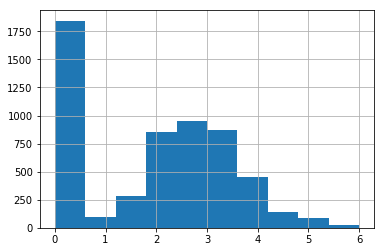

In [82]:
same_df['inf value'].hist()#影响强度的分布

In [83]:
same_num_df=pd.DataFrame(pd.Series(inf_num_value),columns=['inf num'])

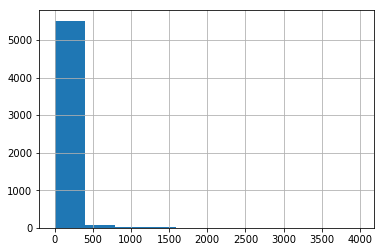

In [86]:
same_num_df['inf num'].hist()#影响人数的分布

In [202]:
sum(same_num_df['inf num'].value_counts().values[:30])

2986

In [88]:
dyn_inf_val={}#存放各个节点的dynamic influencers指标
for key in same_dict.keys():
    dyn_inf_val[key]=same_value[key]+inf_num_value[key]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D9EB7F6198>]],
      dtype=object)

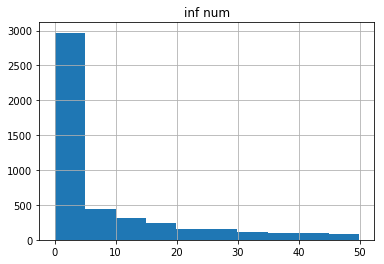

In [203]:
same_num_df[same_num_df['inf num']<50].hist()

In [209]:
dyn_value.head()

,Unnamed: 0,dynamic influencers value
0,754032,3988.935218
1,66915,2770.020897
2,894465,2224.327327
3,120521,1930.431737
4,180228,1592.968769


In [210]:
dyn_value['dynamic influencers value']=dyn_value['dynamic influencers value']/10

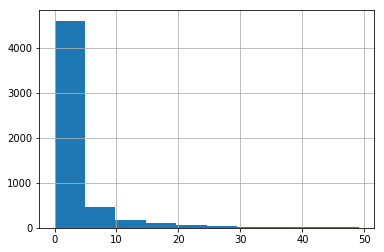

In [215]:
dyn_value[dyn_value['dynamic influencers value']<50]['dynamic influencers value'].hist()

In [89]:
dyn_inf_df=pd.DataFrame(pd.Series(dyn_inf_val),columns=['dynamic influencers value'])

In [91]:
dyn_inf_df.to_csv('dynamic influencers value.csv')

In [92]:
dyn_value=pd.read_csv('dynamic influencers value.csv')

In [146]:
top1000_dyn_id=dyn_value.loc[:,'Unnamed: 0'].values[:1000]#dynamic influencers value前100的

In [98]:
full=pd.read_csv('../problem3 data/full_music plus geners.csv')

In [99]:
full.head()

,Unnamed: 0,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,...,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,0,"[""Fat Freddy's Drop""]",178301,0.600,0.365,0.131,130.046,-13.083,0,9,...,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,NaN
1,1,"[""Fat Freddy's Drop""]",178301,0.874,0.326,0.179,119.620,-13.302,0,11,...,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,NaN
2,2,"[""Fat Freddy's Drop""]",178301,0.670,0.531,0.336,139.385,-8.267,0,9,...,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,NaN
3,3,"[""Alexander O'Neal""]",625201,0.761,0.702,0.850,104.773,-8.523,1,7,...,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,4,"[""Alexander O'Neal""]",625201,0.661,0.828,0.902,115.078,-12.673,0,11,...,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;


In [108]:
full[full['artists_id']==792953]

,Unnamed: 0,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,...,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre


In [148]:
top1000_dyn_id=np.delete(top1000_dyn_id,60)

In [149]:
top1000_field_list=[]
top1000_field_name=[]
for i in top1000_dyn_id:
    top1000_field_list.append(full[full['artists_id']==i]['genre'].values[0])
    top1000_field_name.append(full[full['artists_id']==i]['artist_names'].values[-1])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [138]:
len(top100_field_name)

99

In [140]:
print(top100_field_name)

["['The Beatles']", "['Bob Dylan']", "['The Rolling Stones']", "['Chuck Berry']", "['Elvis Presley']", "['Jimi Hendrix']", "['The Velvet Underground']", "['Hank Williams']", "['The Kinks']", "['Little Richard']", "['The Who']", "['David Bowie']", "['James Brown']", "['Led Zeppelin']", "['Sex Pistols']", "['Buddy Holly']", "['The Stooges']", "['Muddy Waters']", "['The Beach Boys']", "['Bo Diddley']", "['The Yardbirds']", "['Sam Cooke']", '["Howlin\' Wolf"]', "['Smokey Robinson']", "['Black Sabbath']", "['Ray Charles']", "['The Byrds']", "['Marvin Gaye']", "['Pink Floyd']", "['Cream']", "['Miles Davis']", "['The Ramones']", "['Woody Guthrie']", "['Brian Eno']", "['Jimmy Reed']", "['Johnny Cash']", "['The Clash']", "['The Everly Brothers']", "['Neil Young']", "['Billie Holiday']", "['Roxy Music']", "['Jerry Lee Lewis']", "['Kraftwerk']", "['Jackie Wilson']", "['John Coltrane']", "['The Band']", "['Otis Redding']", "['Stevie Wonder']", "['The Isley Brothers']", "['Fats Domino']", "['MC5']"

In [216]:
print(top100_field_list[:15])

['Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Country', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'Pop/Rock', 'R&B;', 'Pop/Rock', 'Pop/Rock']


In [144]:
from collections import Counter
result = Counter(top100_field_list)
print(result)

Counter({'Pop/Rock': 49, 'R&B;': 18, 'Blues': 10, 'Country': 8, 'Jazz': 6, nan: 5, 'Vocal': 1, 'Electronic': 1, 'Folk': 1})


In [208]:
for i in top1000_dyn_id[:15]:
    print(dyn_inf_val[i]/10)

398.89352176847785
277.0020896958038
222.43273273273275
193.04317371202112
159.29687690742625
149.79682694438287
149.7807059855295
142.720301065308
141.4990349847382
140.1922561112357
135.95287494010543
135.93832282471627
127.43102603763857
116.69969084423306
115.11207492795388


## 统计查找RB的dynamic influencers指标

In [151]:
rb_full=full[full['genre']=='R&B;']
rb_full.head()

,Unnamed: 0,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,...,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
3,3,"[""Alexander O'Neal""]",625201,0.761,0.702,0.850,104.773,-8.523,1,7,...,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,4,"[""Alexander O'Neal""]",625201,0.661,0.828,0.902,115.078,-12.673,0,11,...,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
5,5,"[""Alexander O'Neal""]",625201,0.719,0.650,0.953,105.141,-12.947,0,7,...,0.000044,0.1330,0.0265,0,277773,34,1987,7/29/1987,The Lovers,R&B;
6,6,"[""Alexander O'Neal""]",625201,0.649,0.245,0.273,112.709,-17.585,1,11,...,0.000000,0.1740,0.0286,0,312733,29,1987,7/29/1987,Crying Overtime,R&B;
7,7,"[""Alexander O'Neal""]",625201,0.701,0.715,0.735,101.515,-14.999,0,11,...,0.000000,0.3540,0.0291,0,241107,32,1987,7/29/1987,Hearsay,R&B;


In [154]:
rb_id=rb_full['artists_id'].unique()#rb领域的艺术家id

In [155]:
rf_dyn_if_df=pd.DataFrame()

In [156]:
rf_dyn_if_df['id']=rb_id

In [159]:
inf_id=inf_data['influencer_id'].unique()#influencer_id
fol_id=[]#follower_id
for ida in inf_data['follower_id'].unique():
    if ida not in inf_id:
        fol_id.append(ida)

In [161]:
year_dict={}#记录各个歌手开始活跃的年份
for ida in rb_id:
    if ida in inf_id:
        year_dict[ida]=inf_data[inf_data['influencer_id']==ida]['influencer_active_start'].values[0]
    elif ida in fol_id:
        year_dict[ida]=inf_data[inf_data['follower_id']==ida]['follower_active_start'].values[0]
    else:
        continue

In [157]:
inf_data.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [166]:
dyn_inf_dict={}#记录各个歌手的dynamic influencers指标
for key in year_dict.keys():
    dyn_inf_dict[key]=same_value[key]

In [168]:
ser1=pd.Series(year_dict)
ser2=pd.Series(dyn_inf_dict)

In [179]:
dyn_inf_df=pd.DataFrame()

In [187]:
year_list=year_dict.values()
dyn_inf_list=dyn_inf_dict.values()
id_list=year_dict.keys()

In [188]:
dyn_inf_df['year']=year_list
dyn_inf_df['dynamic influencers value']=dyn_inf_list
dyn_inf_df['id']=id_list

In [194]:
dyn_inf_df.groupby('year').sum()['dynamic influencers value'].values#各个年份对应的dynamic influencers value之和

array([  2.33829787,  34.67210658, 194.94935577, 273.2424843 ,
       167.9745054 , 142.02935254, 213.95613975, 107.875     ,
         9.66666667])

In [195]:
dyn_inf_df.groupby('year').sum().index

Int64Index([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010], dtype='int64', name='year')

In [197]:
dyn_inf_df.groupby('year').count()['dynamic influencers value'].values#各个年份对应的人数

array([  1,  15,  75, 112,  85,  71, 109,  75,  41], dtype=int64)

In [217]:
target_df=inf_data[inf_data['influencer_active_start']>=1970]
target_df=target_df[target_df['influencer_active_start']<=1980]
target_df=target_df[target_df['influencer_main_genre']=='R&B;']

In [220]:
target_df['influencer_id'].unique()

array([208774, 262255, 820434, 661524, 279337, 361393, 614823, 816701,
        41420, 101953, 118289, 509356, 664849, 746666, 865016, 894847,
       803242, 137084, 302106, 790833, 107139, 191947, 798792,  92942,
        18258, 127063, 651156, 767016,  47421,  61044,  96379, 572579,
       944349, 305501, 140816,  35076, 161920, 131624,  61226, 607773,
       299668, 921002, 267814,  20278, 160638, 799081, 884962, 743968,
       628684, 772721, 935330,  18176, 816517, 930642, 180449, 208076,
       243474, 517074, 361973, 402249, 680374, 583935, 790667, 898188,
        35338, 167386, 193025, 330453,  30928, 788937, 869409, 317108,
       625201, 756291, 596451, 359559, 190531, 333573, 755570, 755792,
       767095,  17877, 401114, 152228, 399437, 165345, 108124, 221894,
       411830, 806507, 253734, 314505, 241004, 649435, 118128, 276381,
       380235, 333447, 293897, 795841, 367417, 247824,  59503,  25778,
       793664,  49367, 147082, 574483, 147294, 107249, 818254,  38805,
      

In [221]:
target_dict_inf_value={}
for ida in target_df['influencer_id'].unique():
    target_dict_inf_value[ida]=dyn_inf_val[ida]

In [222]:
line1=target_dict_inf_value.values()
line2=target_dict_inf_value.keys()


In [223]:
target2_df=pd.DataFrame()
target2_df['id']=line2
target2_df['value']=line1

In [226]:
target2_df.sort_values(by="value" , ascending=False) .head()

,id,value
23,92942,333.014201
5,361393,293.848684
0,208774,216.645217
3,661524,178.875197
55,208076,171.205732


In [231]:
lista=target2_df.sort_values(by="value" , ascending=False) .loc[:15,'id'].values

In [232]:
lista

array([ 92942, 361393, 208774, 661524, 208076,  20278, 820434, 107139,
        61044, 262255, 865016, 798792,  18258, 756291, 572579, 191947,
       767016, 118289, 279337, 894847], dtype=int64)

In [239]:
inf_data[inf_data['influencer_id'] ==208774]

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
123,208774,Janet Jackson,R&B;,1970,2750,Total,R&B;,1990
191,208774,Janet Jackson,R&B;,1970,4852,Selena,Latin,1980
207,208774,Janet Jackson,R&B;,1970,5307,Alicia Keys,R&B;,1990
414,208774,Janet Jackson,R&B;,1970,7689,TLC,R&B;,1990
543,208774,Janet Jackson,R&B;,1970,8828,Spice Girls,Pop/Rock,1990
1891,208774,Janet Jackson,R&B;,1970,27136,Paulina Rubio,Latin,1980
2156,208774,Janet Jackson,R&B;,1970,31380,Paula Abdul,Pop/Rock,1980
2752,208774,Janet Jackson,R&B;,1970,38805,Angie Stone,R&B;,1970
3875,208774,Janet Jackson,R&B;,1970,57151,B*Witched,Pop/Rock,1990
4807,208774,Janet Jackson,R&B;,1970,73682,Kelly Rowland,R&B;,1990
